## **[An Introduction to Statistical Learning, With Applications in R (ISLR)](https://www.statlearning.com/)**

## Lab: Deep Learning

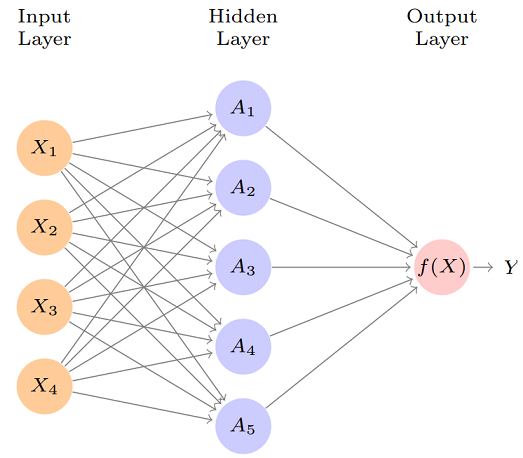

## What is ISLR?

`ISLR (Introduction to Statistical Learning with R)` is a package that provides datasets and various helper functions for statistical learning labs. It’s a valuable resource for anyone interested in exploring statistical concepts and applying them using R. Whether you’re a student, researcher, or data enthusiast, ISLR can assist you in understanding and experimenting with statistical methods. 📊🔍



---



---



## Part Zero
### START CODING

### Import Libraries

In [ ]:
install.packages("ISLR2", dependencies = TRUE)
install.packages("MASS")
install.packages("glmnet", dependencies = TRUE)
install.packages("keras", dependencies = TRUE)
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’, ‘lars’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’, ‘tfdatasets’, ‘png’, ‘jpeg’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)





---



---



## Part One
### A Single Layer Network on the Hitters Data

We start by fitting the models on the `Hitters` data.

###Hitters data explanation:

This is a regression problem, where the goal is to predict the `Salary` of
a baseball player in $1987$ using his performance statistics from $1986$. After
removing players with missing responses, we are left with $263$ players and
$19$ variables. We randomly split the data into a training set of $176$ players
(two thirds), and a test set of 87 players (one third). We used three methods for fitting a regression model to these data:
*   A linear model was used to fit the training data, and make predictions on the test data. The model has $20$ parameters.
*   The same linear model was fit with lasso regularization. The tuning parameter was selected by $10$-fold cross-validation on the training data. It selected a model with $12$ variables having nonzero coefficients.
*   A neural network with one hidden layer consisting of $64$ ReLU units was fit to the data. This model has $1,345$ parameters.

We set up the data, and separate out a training and test set.

In [ ]:
library(ISLR2)

Gitters <- na.omit(Hitters)
n <- nrow(Gitters)
set.seed(13)
ntest <- trunc(n / 3)
testid <- sample(1:n, ntest)

We present a linear model:

In [ ]:
lfit <- lm(Salary ~ ., data = Gitters[-testid, ])
lpred <- predict(lfit, Gitters[testid, ])
round( (with(Gitters[testid, ], mean(abs(lpred - Salary))) )  , digits=4 )

[1] 254.6687

Notice the use of the `with()` command: the first argument is a dataframe, and the second an expression that can refer to elements of the dataframe
by name.

In this instance the dataframe corresponds to the test data and
the expression computes the mean absolute prediction error on this data.

Next we fit the lasso using `glmnet`. Since this package does not use formulas, we create `x` and `y` first:

In [ ]:
x <- scale(model.matrix(Salary ~ . -1, data = Gitters))
y <- Gitters$Salary

The first line makes a call to `model.matrix()`, which produces the same
matrix that was used by `lm()` (the `-1` omits the intercept). This function
automatically converts factors to dummy variables.

The `scale()` function
standardizes the matrix so each column has mean zero and variance one.

In [ ]:
library(glmnet)

cvfit <- cv.glmnet(x[-testid, ], y[-testid],
                   type.measure = "mae")
cpred <- predict(cvfit, x[testid, ], s = "lambda.min")
round( mean(abs(y[testid] - cpred)) , digits=4 )

Loading required package: Matrix

Loaded glmnet 4.1-8



[1] 252.2994

To fit the neural network, we first set up a model structure that describes
the network.

In [ ]:
library(keras)

modnn <- keras_model_sequential() %>%
  layer_dense(units = 50, activation = "relu", input_shape = ncol(x)) %>%
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = 1)

We have created a vanilla model object called `modnn`, and have added details about the successive layers in a sequential manner, using the function
`keras_model_sequential()`.

The $pipe$ operator `%>%` passes the previous term as the first argument to the next function, and returns the result. It allows
us to specify the layers of a neural network in a readable form.


NOTE (pipe operator %>%):
```
We illustrate the use of the pipe operator on a simple example. Earlier, we created `x` using command below:

x <- scale(model.matrix(Salary ~ . -1, data = Gitters))

We first make a matrix, and then we center each of the variables. Compound expressions like this can be difficult
to parse. We could have obtained the same result using the pipe operator:

x <- model.matrix(Salary ~ . -1, data = Gitters) %>% scale()
```
Using the pipe operator makes it easier to follow the sequence of operations.


We now return to our neural network. The object `modnn` has a single hidden layer with $50$ hidden units, and a ReLU activation function. It then has
a dropout layer, in which a random $40\%$ of the $50$ activations from the previous layer are set to zero during each iteration of the stochastic gradient
descent algorithm. Finally, the output layer has just one unit with no activation function, indicating that the model provides a single quantitative
output.

Next we add details to `modnn` that control the fitting algorithm. We minimize
squared-error loss as in

$$
minimize_{{\{w}_k\}_1^K, \beta }\frac{1}{2}\sum_{i=1}^{n} ({y}_i-f(x_i))^2
$$


The algorithm tracks the mean absolute error on the training data, and on validation data if it is supplied.

In [ ]:
modnn %>% compile(loss = "mse",
                  optimizer = optimizer_rmsprop(),
                  metrics = list("mean_absolute_error"))

In the previous line, the pipe operator passes `modnn` as the first argument
to `compile()`. The `compile()` function does not actually change the `R` object `modnn`, but it does communicate these specifcations to the corresponding `python` instance of this model that has been created along the way.

Now we fit the model. We supply the training data and two fitting parameters, `epochs` and `batch_size`. Using $32$ for the latter means that at each
step of **SGD**, the algorithm randomly selects $32$ training observations for
the computation of the gradient.

>Recall from previous sections that an epoch amounts to the number of **SGD** steps required to process $n$ observations. Since the training set has n = $176$, an epoch is $176/32 = 5.5$ **SGD** steps.

The `fit()` function has an argument `validation_data`; these data are
not used in the fitting, but can be used to track the progress of the model
(in this case reporting the mean absolute error). Here we actually supply
the test data so we can see the mean absolute error of both the training
data and test data as the epochs proceed.

In [ ]:
history <- modnn %>% fit(x[-testid, ], y[-testid],
                         epochs = 1500, batch_size = 32,
                         validation_data = list(x[testid, ], y[testid]))


> To see more options for fitting, use `?fit.keras.engine.training.Model`.

In [ ]:
?fit.keras.engine.training.Model

We can plot the `history` to display the mean absolute error for the training
and test data.

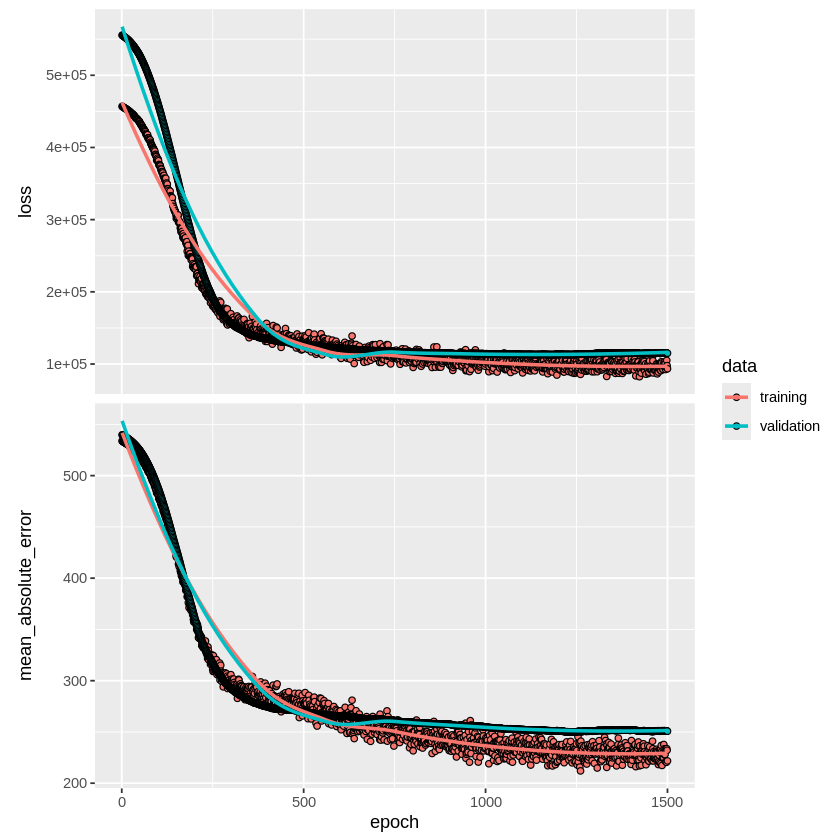

In [ ]:
plot(history)

It is worth noting that if you run the `fit()` command a second time in the
same **R** session, then the fitting process will pick up where it left of.

Try re-running the `fit()` command, and then the `plot()` command, to see!

Finally, we predict from the final model, and evaluate its performance
on the test data. Due to the use of **SGD**, the results vary slightly with each
fit. Unfortunately the `set.seed()` function does not ensure identical results
(since the ftting is done in `python`), so your results will differ slightly.

In [ ]:
npred <- predict(modnn, x[testid, ])
round( mean(abs(y[testid] - npred)) , digits=4 )

[1] 250.7388



---



---



## Part Two
### A Multilayer Network on the MNIST Digit Data

The `keras` package comes with a number of example datasets, including the `MNIST` digit data. Our frst step is to load the `MNIST` data. The
`dataset_mnist()` function is provided for this purpose.

In [ ]:
mnist <- dataset_mnist()
x_train <- mnist$train$x
g_train <- mnist$train$y
x_test <- mnist$test$x
g_test <- mnist$test$y

In [ ]:
dim(x_train)

[1] 60000    28    28

In [ ]:
dim(x_test)

[1] 10000    28    28

There are $60,000$ images in the training data and $10,000$ in the test data.
The images are $28×28$, and stored as a three-dimensional array, so we need
to reshape them into a matrix. Also, we need to “one-hot” encode the class
label. Luckily `keras` has a lot of built-in functions that do this for us.

In [ ]:
x_train <- array_reshape(x_train, c(nrow(x_train), 784))
x_test <- array_reshape(x_test, c(nrow(x_test), 784))
y_train <- to_categorical(g_train, 10)
y_test <- to_categorical(g_test, 10)

Neural networks are somewhat sensitive to the scale of the inputs. For
example, ridge and lasso regularization are afected by scaling. Here the
inputs are eight-bit grayscale values between 0 and 255, so we rescale to
the unit interval.


> Note: eight bits means $2^8$, which equals $256$. Since the convention is to start at 0, the possible values range from $0$ to $255$.

In [ ]:
x_train <- x_train / 255
x_test <- x_test / 255

Now we are ready to fit our neural network.

In [ ]:
modelnn <- keras_model_sequential()
modelnn %>%
  layer_dense(units = 256, activation = "relu", input_shape = c(784)) %>%
  layer_dropout(rate = 0.4) %>%
  layer_dense(units = 128, activation = "relu") %>%
  layer_dropout(rate = 0.3) %>%
  layer_dense(units = 10, activation = "softmax")

The first layer goes from $28 × 28 = 784$ input units to a hidden layer of
$256$ units, which uses the ReLU activation function. This is specifed by a
call to `layer_dense()`, which takes as input a `modelnn` object, and returns a modifed `modelnn` object. This is then piped through `layer_dropout()` to perform dropout regularization. The second hidden layer comes next, with
$128$ hidden units, followed by a dropout layer. The final layer is the output layer, with activation `"softmax"` for the $10$-class classifcation
problem, which defines the map from the second hidden layer to class probabilities.

Finally, we use `summary()` to summarize the model, and to make
sure we got it all right.

In [ ]:
summary(modelnn)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_4 (Dense)                    (None, 256)                     200960      
 dropout_2 (Dropout)                (None, 256)                     0           
 dense_3 (Dense)                    (None, 128)                     32896       
 dropout_1 (Dropout)                (None, 128)                     0           
 dense_2 (Dense)                    (None, 10)                      1290        
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


The parameters for each layer include a bias term, which results in a
parameter count of $235,146$. For example, the first hidden layer involves
$(784 + 1) × 256 = 200,960$ parameters.

> Notice that the layer names such as `dropout_1` and `dense_2` have subscripts. These may appear somewhat random; in fact, if you fit the same
model again, these will change. They are of no consequence: they vary because the model specification code is run in `python`, and these subscripts
are incremented every time `keras_model_sequential()` is called.

Next, we add details to the model to specify the ftting algorithm. We
fit the model by minimizing the cross-entropy function:
$$
-\sum_{i=1}^{n}\sum_{m=0}^{9} {y}_{im}log({f}_m({x}_i))
$$

In [ ]:
modelnn %>% compile(loss = "categorical_crossentropy",
                    optimizer = optimizer_rmsprop(),
                    metrics = c("accuracy"))

Now we are ready to go. The final step is to supply training data, and
fit the model.

In [ ]:
system.time(
  history <- modelnn %>%
    fit(x_train, y_train,
        epochs = 30, batch_size = 128,
        validation_split = 0.2)
           )

   user  system elapsed 
141.689   7.199 143.360 

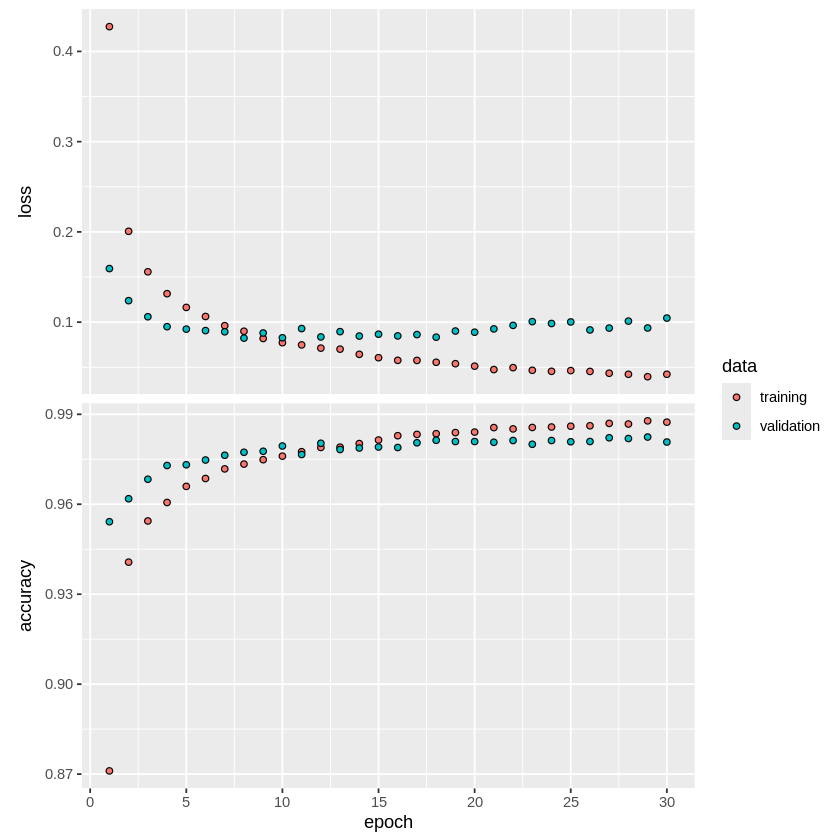

In [ ]:
plot(history, smooth = FALSE)

We have suppressed the output here, which is a progress report on the
fitting of the model, grouped by epoch. This is very useful, since on large
datasets fitting can take time. Here we specifed a validation split of $20\%$, so the training is actually performed on
$80\%$ of the $60,000$ observations in the training set. This is an alternative
to actually supplying validation data.

**SGD** uses batches of $128$ observations in computing the gradient, and doing the arithmetic, we see that an epoch corresponds to $375$ gradient steps.

Method                                  | Test Error
----------------------------------------|-------------
Neural Network + Ridge Regularization   |     2.3%   
Neural Network + Dropout Rugularization |     1.8%
Multinomial Logistic Regression         |     7.2%    
Linear Discriminant Analysis            |    12.7%


To obtain the test error in above Table, we first write a simple function
`accuracy()` that compares predicted and true class labels, and then use it
to evaluate our predictions.

In [ ]:
accuracy <- function(pred, truth)
   mean(drop(as.numeric(pred)) == drop(truth))
modelnn %>% predict(x_test) %>% k_argmax() %>% accuracy(g_test)

[1] 0.9822

Although packages such as `glmnet` can handle multiclass logistic regression,
they are quite slow on this large dataset.

It is much faster and quite easy
to fit such a model using the `keras` software. We just have an input layer
and output layer, and omit the hidden layers!

In [ ]:
modellr <- keras_model_sequential() %>%
  layer_dense(input_shape = 784,
              units = 10,
              activation = "softmax")
summary(modellr)

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_5 (Dense)                    (None, 10)                      7850        
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


We fit the model just as before.

In [ ]:
modellr %>% compile(loss = "categorical_crossentropy",
                    optimizer = optimizer_rmsprop(),
                    metrics = c("accuracy"))

modellr %>% fit(x_train, y_train,
                epochs = 30, batch_size = 128,
                validation_split = 0.2)

modellr %>% predict(x_test) %>% k_argmax() %>% accuracy(g_test)

[1] 0.926



---



---



## Part Three
### Convolutional Neural Networks

In this section we fit a **CNN** to the `CIFAR100` data, which is available in the `keras` package. It is arranged in a similar fashion as the `MNIST` data.

In [ ]:
cifar100 <- dataset_cifar100()
names(cifar100)

[1] "train" "test"

In [ ]:
x_train <- cifar100$train$x
g_train <- cifar100$train$y
x_test <- cifar100$test$x
g_test <- cifar100$test$y

In [ ]:
dim(x_train)

[1] 50000    32    32     3

In [ ]:
range(x_train[1,,, 1])

[1]  13 255

The array of $50,000$ training images has four dimensions: each three-color
image is represented as a set of three channels, each of which consists of
$32 × 32$ eight-bit pixels. We standardize as we did for the digits, but keep
the array structure. We one-hot encode the response factors to produce a
$100$-column binary matrix.

In [ ]:
x_train <- x_train / 255
x_test <- x_test / 255
y_train <- to_categorical(g_train, 100)

In [ ]:
dim(y_train)

[1] 50000   100

Before we start, we look at some of the training images using the `jpeg` package.

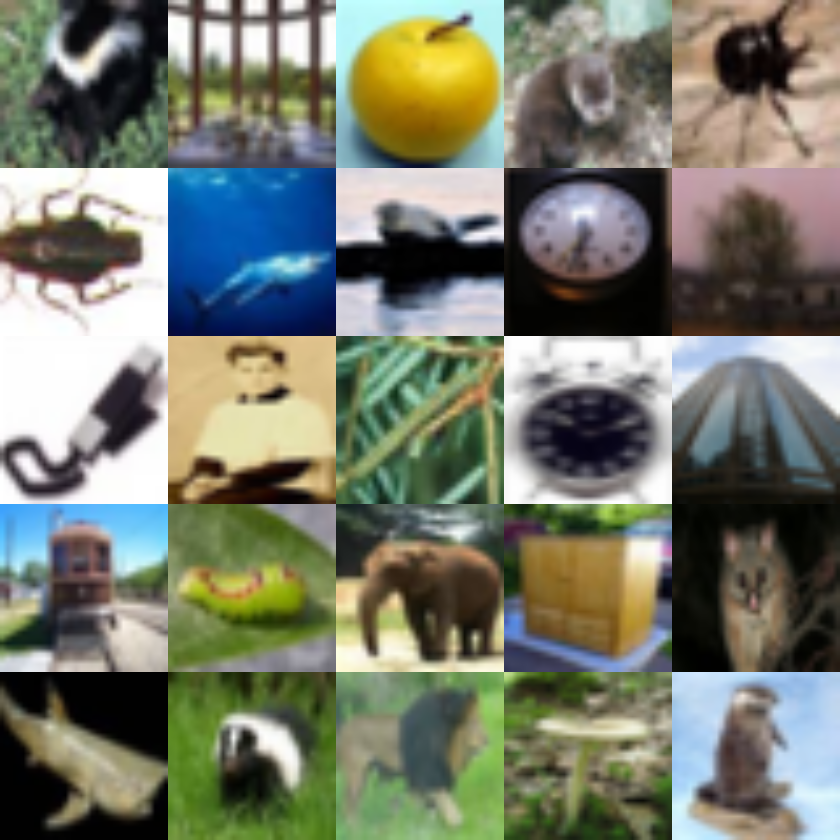

In [ ]:
library(jpeg)

par(mar = c(0, 0, 0, 0), mfrow = c(5, 5) )
index <- sample(seq(50000), 25)
for (i in index) plot(as.raster(x_train[i,,, ]))

The `as.raster()` function converts the feature map so that it can be plotted as a color image.

Here we specify a moderately-sized **CNN** for demonstration purposes, similar in structure to this figure:

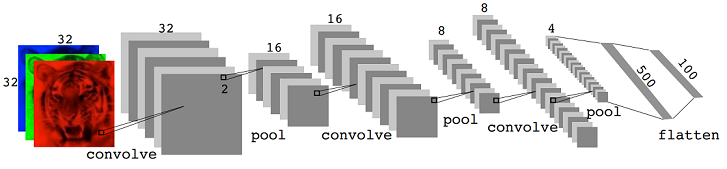

In [ ]:
model <- keras_model_sequential() %>%
  layer_conv_2d(filters = 32, kernel_size = c(3, 3),
                padding = "same", activation = "relu",
                input_shape = c(32, 32, 3) ) %>%
  layer_max_pooling_2d(pool_size = c(2, 2) ) %>%
  layer_conv_2d(filters = 64, kernel_size = c(3, 3),
                padding = "same", activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2) ) %>%
  layer_conv_2d(filters = 128, kernel_size = c(3, 3),
                padding = "same", activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2) ) %>%
  layer_conv_2d(filters = 256, kernel_size = c(3, 3),
                padding = "same", activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2) ) %>%
  layer_flatten() %>%
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 512, activation = "relu") %>%
  layer_dense(units = 100, activation = "softmax")

In [ ]:
summary(model)

Model: "sequential_9"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_7 (Conv2D)                  (None, 32, 32, 32)              896         
 max_pooling2d_7 (MaxPooling2D)     (None, 16, 16, 32)              0           
 conv2d_6 (Conv2D)                  (None, 16, 16, 64)              18496       
 max_pooling2d_6 (MaxPooling2D)     (None, 8, 8, 64)                0           
 conv2d_5 (Conv2D)                  (None, 8, 8, 128)               73856       
 max_pooling2d_5 (MaxPooling2D)     (None, 4, 4, 128)               0           
 conv2d_4 (Conv2D)                  (None, 4, 4, 256)               295168      
 max_pooling2d_4 (MaxPooling2D)     (None, 2, 2, 256)               0           
 flatten_1 (Flatten)                (None, 1024)                    0           
 dropout_5 (Dropout)                (None, 1024)                    0           
 dense

Notice that we used the `padding = "same"` argument to `layer_conv_2D()`, which ensures that the output channels have the same dimension as the
input channels.

There are $32$ channels in the first hidden layer, in contrast
to the three channels in the input layer. We use a $3 × 3$ convolution filter
for each channel in all the layers. Each convolution is followed by a maxpooling layer over $2 × 2$ blocks.

By studying the summary, we can see that the channels halve in both dimensions after each of these max-pooling operations. After the last of these we have a layer with $256$ channels of dimension $2 × 2$. These are then flattened to a dense layer of size $1,024$:

in other words, each of the $2 × 2$ matrices is turned into a $4$-vector, and put side-by-side in one layer. This is followed by a dropout regularization
layer, then another dense layer of size $512$, which finally reaches the softmax
output layer.

Finally, we specify the fitting algorithm, and fit the model.

In [ ]:
model %>% compile(loss = "categorical_crossentropy",
                  optimizer = optimizer_rmsprop(),
                  metrics = c("accuracy") )

history <- model %>% fit(x_train, y_train,
                         epochs = 30, batch_size = 128,
                         validation_split = 0.2)

model %>% predict(x_test) %>% k_argmax() %>% accuracy(g_test)

[1] 0.4479

This model takes several minutes to run and achieves $46\%$ accuracy on the test
data. Although this is not terrible for $100$-class data (a random classifer
gets $1\%$ accuracy), searching the web we see results around $75\%$. Typically
it takes a lot of architecture carpentry, fiddling with regularization, and
time to achieve such results.



---



---



## Part Four
### Using Pretrained CNN Models

We now show how to use a **CNN** pretrained on the `imagenet` database to
classify natural images, and demonstrate how we produced this figure:

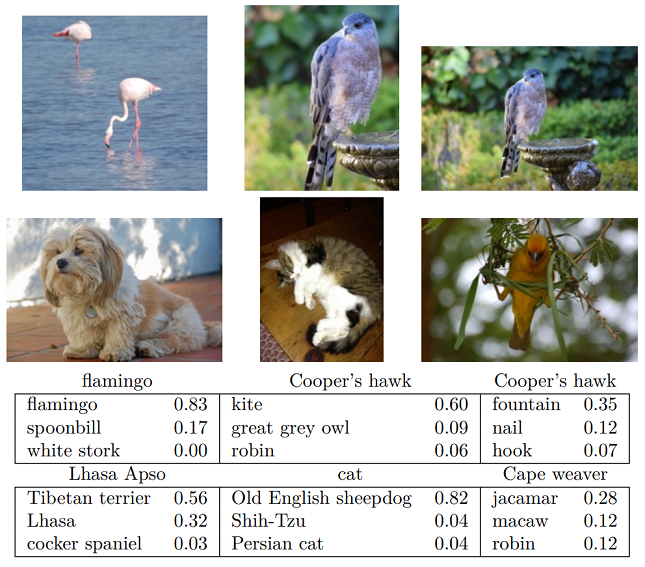

We copied six jpeg images from a digital photo album into the directory
`book_images`.

> These images are available from the data section of [the ISL book website](www.statlearning.com). Download [book_images.zip](https://www.statlearning.com/s/book_images.zip); when clicked it creates the book_images directory.

We first read in the images, and convert them into the array format expected by the `keras` software to match the specifcations in `imagenet`.


> Make sure that your working directory in `R` is set to the folder in
which the images are stored.

In [ ]:
img_dir <- "book_images"
image_names <- list.files(img_dir)
num_images <- length(image_names)
x <- array(dim = c(num_images, 224, 224, 3) )
for (i in 1:num_images) {
  img_path <- paste(img_dir, image_names[i], sep = "/")
  img <- image_load(img_path, target_size = c(224, 224) )
  x[i,,, ] <- image_to_array(img)
}
x <- imagenet_preprocess_input(x)

We then load the trained network. The model has $50$ layers, with a fair bit
of complexity

In [ ]:
model <- application_resnet50(weights = "imagenet")
summary(model)

Model: "resnet50"
________________________________________________________________________________
 Layer (type)       Output Shape         Para   Connected to         Trainable  
                                         m #                                    
 input_1 (InputLay  [(None, 224, 224,    0      []                   Y          
 er)                3)]                                                         
 conv1_pad (ZeroPa  (None, 230, 230, 3   0      ['input_1[0][0]']    Y          
 dding2D)           )                                                           
 conv1_conv (Conv2  (None, 112, 112, 6   9472   ['conv1_pad[0][0]'   Y          
 D)                 4)                          ]                               
 conv1_bn (BatchNo  (None, 112, 112, 6   256    ['conv1_conv[0][0]   Y          
 rmalization)       4)                          ']                              
 conv1_relu (Activ  (None, 112, 112, 6   0      ['conv1_bn[0][0]']   Y          
 ation)   

Finally, we classify our six images, and return the top three class choices
in terms of predicted probability for each.

In [ ]:
pred6 <- model %>% predict(x) %>%
  imagenet_decode_predictions(top = 3)
names(pred6) <- image_names
print(pred6)

$flamingo.jpg
  class_name class_description      score
1  n02007558          flamingo 0.92634964
2  n02006656         spoonbill 0.07169954
3  n02002556       white_stork 0.00122821

$hawk_cropped.jpeg
  class_name class_description      score
1  n01608432              kite 0.72270870
2  n01622779    great_grey_owl 0.08182582
3  n01532829       house_finch 0.04218887

$hawk.jpg
  class_name class_description     score
1  n03388043          fountain 0.2788655
2  n03532672              hook 0.1785543
3  n03804744              nail 0.1080729

$huey.jpg
  class_name           class_description      score
1  n02097474             Tibetan_terrier 0.50929737
2  n02098413                       Lhasa 0.42209837
3  n02098105 soft-coated_wheaten_terrier 0.01695859

$kitty.jpg
  class_name    class_description      score
1  n02105641 Old_English_sheepdog 0.83266032
2  n02086240             Shih-Tzu 0.04513871
3  n03223299              doormat 0.03299762

$weaver.jpg
  class_name class_description 

## Part Five
### IMDB Document Classification

Now we perform document classifcation on the `IMDb` dataset, which is available as part of the `keras` package. We limit the dictionary size to the $10,000$ most frequently-used words and tokens.

In [ ]:
max_features <- 10000
imdb <- dataset_imdb(num_words = max_features)
c(c(x_train, y_train), c(x_test, y_test) ) %<-% imdb

The third line is a shortcut for unpacking the list of lists. Each element
of `x_train` is a vector of numbers between $0$ and $9999$ (the document),
referring to the words found in the dictionary.

For example, the first training document is this positive review:


> \<START\> this film was just brilliant casting location scenery
story direction everyone’s really suited the part they played and you could just imagine being there robert \<UNK\> is an amazing
actor and now the same being director \<UNK\> father came from
the same scottish island as myself so i loved ...


The indices of the first $12$ words are given below:

In [ ]:
x_train[[1]][1:12]

[1]    1   14   22   16   43  530  973 1622 1385   65  458 4468

To see the words, we create a function, `decode_review()`, that provides a
simple interface to the dictionary.

In [ ]:
word_index <- dataset_imdb_word_index()
decode_review <- function(text, word_index) {
  word <- names(word_index)
  idx <- unlist(word_index, use.names = FALSE)
  word <- c("<PAD>", "<START>", "<UNK>", "<UNUSED>", word)
  idx <- c(0:3, idx + 3)
  words <- word[match(text, idx, 2) ]
  paste(words, collapse = " ")
}
decode_review(x_train[[1]][1:12], word_index)

[1] "<START> this film was just brilliant casting location scenery story direction everyone's"

Next we write a function to “one-hot” encode each document in a list of
documents, and return a binary matrix in sparse-matrix format.

In [ ]:
library(Matrix)

one_hot <- function(sequences, dimension) {
  seqlen <- sapply(sequences, length)
  n <- length(seqlen)
  rowind <- rep(1:n, seqlen)
  colind <- unlist(sequences)
  sparseMatrix(i = rowind, j = colind, dims = c(n, dimension))
}

To construct the sparse matrix, one supplies just the entries that are
nonzero. In the last line we call the function `sparseMatrix()` and supply
the row indices corresponding to each document and the column indices
corresponding to the words in each document, since we omit the values
they are taken to be all ones. Words that appear more than once in any
given document still get recorded as a one.

In [ ]:
x_train_1h <- one_hot(x_train, 10000)
x_test_1h <- one_hot(x_test, 10000)

In [ ]:
dim(x_train_1h)

[1] 25000 10000

In [ ]:
round( nnzero(x_train_1h) / (25000 * 10000)  , digits = 4 )

[1] 0.0132

Only $1.3\%$ of the entries are nonzero, so this amounts to considerable savings in memory. We create a validation set of size $2,000$, leaving $23,000$ for
training.

In [ ]:
set.seed(3)
ival <- sample(seq(along = y_train) , 2000)

First we fit a lasso logistic regression model using `glmnet()` on the training
data, and evaluate its performance on the validation data. Finally, we plot
the accuracy, `acclmv`, as a function of the shrinkage parameter, λ. Similar
expressions compute the performance on the test data, and were used to
produce this plot:

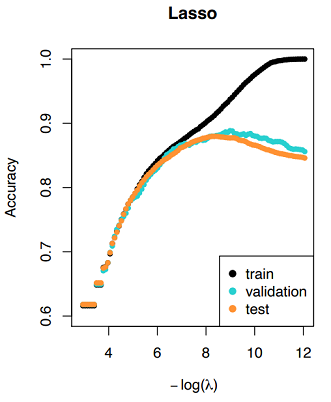

The code takes advantage of the sparse-matrix format of `x_train_1h`, and runs in about $5$ seconds; in the usual dense format it would take about $5$ minutes.

In [ ]:
library(glmnet)

fitlm <- glmnet(x_train_1h[-ival, ] , y_train[-ival] ,
                family = "binomial", standardize = FALSE)
classlmv <- predict(fitlm, x_train_1h[ival, ]) > 0
acclmv <- apply(classlmv, 2, accuracy, y_train[ival] > 0)

We applied the `accuracy()` function that we wrote in this cell in Part two to every column of the prediction matrix `classlmv`,
```
                    accuracy <- function(pred, truth)
                      mean(drop(as.numeric(pred)) == drop(truth))
                    modelnn %>% predict(x_test) %>% k_argmax() %>% accuracy(g_test)
```
and since this is a logical matrix of `TRUE/FALSE` values, we supply the second argument `truth` as a logical vector as well.

Before making a plot, we adjust the plotting window:

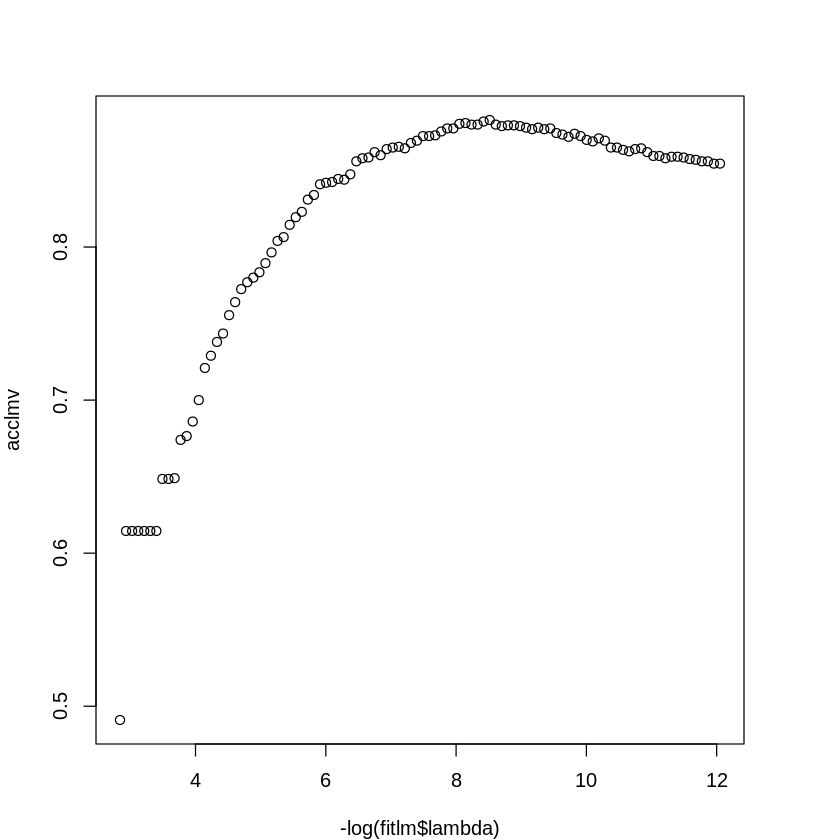

In [ ]:
par(mar = c(4, 4, 4, 4) , mfrow = c(1, 1) )
plot(-log(fitlm$lambda) , acclmv)

Next we fit a fully-connected neural network with two hidden layers, each
with $16$ units and ReLU activation.

In [ ]:
model <- keras_model_sequential() %>%
  layer_dense(units = 16, activation = "relu",
              input_shape = c(10000) ) %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dense(units = 1, activation = "sigmoid")

model %>% compile(optimizer = "rmsprop",
                  loss = "binary_crossentropy",
                  metrics = c("accuracy") )

history <- model %>% fit(x_train_1h[-ival, ], y_train[-ival],
                         epochs = 20, batch_size = 512,
                         validation_data = list(x_train_1h[ival, ], y_train[ival]))

In [ ]:
summary(model)

Model: "sequential_4"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_10 (Dense)                   (None, 16)                      160016      
 dense_9 (Dense)                    (None, 16)                      272         
 dense_8 (Dense)                    (None, 1)                       17          
Total params: 160305 (626.19 KB)
Trainable params: 160305 (626.19 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


The `history` object has a `metrics` component that records both the training and validation accuracy at each epoch.

To compute the test accuracy, we rerun the entire sequence above, With the following changes in `history` part:

In [ ]:
model <- keras_model_sequential() %>%
  layer_dense(units = 16, activation = "relu",
              input_shape = c(10000) ) %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dense(units = 1, activation = "sigmoid")

model %>% compile(optimizer = "rmsprop",
                  loss = "binary_crossentropy",
                  metrics = c("accuracy") )

history <- model %>% fit(x_train_1h[-ival, ], y_train[-ival],
                         epochs = 20, batch_size = 512,
                         validation_data = list(x_test_1h, y_test))

## Part Six
### Recurrent Neural Networks

### Sequential Models for Document Classification:

Here we fit a simple `LSTM RNN` for sentiment analysis with the `IMDb` movie-review data. We showed how to input the data in previous part, so there is some repeated lines here:

In [ ]:
max_features <- 10000
imdb <- dataset_imdb(num_words = max_features)
c(c(x_train, y_train), c(x_test, y_test) ) %<-% imdb

We first calculate the lengths of the documents:

In [ ]:
wc <- sapply(x_train, length)
median(wc)

[1] 178

In [ ]:
round(sum(wc <= 500) / length(wc)  , digits=4)

[1] 0.9157

We see that over $91\%$ of the documents have fewer than $500$ words. Our
**RNN** requires all the document sequences to have the same length. We
hence restrict the document lengths to the last $L = 500$ words, and pad
the beginning of the shorter ones with blanks.

In [ ]:
maxlen <- 500
x_train <- pad_sequences(x_train, maxlen = maxlen)
x_test <- pad_sequences(x_test, maxlen = maxlen)

In [ ]:
dim(x_train)

[1] 25000   500

In [ ]:
dim(x_test)

[1] 25000   500

In [ ]:
x_train[1, 490:500]

[1]   16 4472  113  103   32   15   16 5345   19  178   32

The last expression shows the last few words in the first document. At this
stage, each of the $500$ words in the document is represented using an integer
corresponding to the location of that word in the $10,000$-word dictionary.

The first layer of the **RNN** is an embedding layer of size $32$, which will be learned during training. This layer one-hot encodes each document as a
matrix of dimension $500×10, 000$, and then maps these $10, 000$ dimensions
down to $32$.


In [ ]:
model <- keras_model_sequential() %>%
  layer_embedding(input_dim = 10000, output_dim = 32) %>%
  layer_lstm(units = 32) %>%
  layer_dense(units = 1, activation = "sigmoid")

The second layer is an **LSTM** with $32$ units, and the output layer is a single sigmoid for the binary classification task.

The rest is now similar to other networks we have fit. We track the test
performance as the network is fit, and see that it attains $87\%$ accuracy.

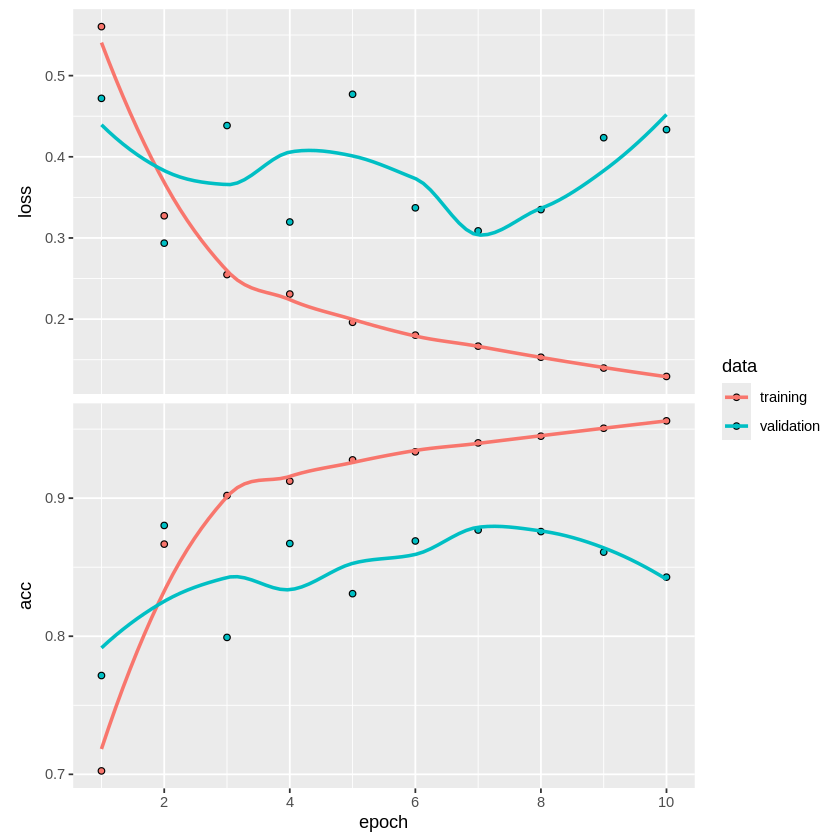

In [ ]:
model %>% compile(optimizer = "rmsprop",
                  loss = "binary_crossentropy",
                  metrics = c("acc") )

history <- model %>% fit(x_train, y_train,
                         epochs = 10, batch_size = 128,
                         validation_data = list(x_test, y_test) )

plot(history)

In [ ]:
predy <- predict(model, x_test) > 0.5
round( mean(abs(y_test == as.numeric(predy)))  , digits=4 )

[1] 0.8428

### Time Series Prediction

We now show how to fit the models for time series prediction. We first set up the data, and standardize each of the variables

In [ ]:
library(ISLR2)

xdata <- data.matrix(
  NYSE[, c("DJ_return", "log_volume", "log_volatility")]
                    )
istrain <- NYSE[, "train"]
xdata <- scale(xdata)

The variable `istrain` contains a `TRUE` for each year that is in the training
set, and a `FALSE` for each year in the test set.

We first write functions to create lagged versions of the three time series.
We start with a function that takes as input a data matrix and a lag $L$,
and returns a lagged version of the matrix. It simply inserts $L$ rows of `NA`
at the top, and truncates the bottom.

In [ ]:
lagm <- function(x, k = 1) {
  n <- nrow(x)
  pad <- matrix(NA, k, ncol(x))
  rbind(pad, x[1:(n - k), ])
}

We now use this function to create a data frame with all the required lags,
as well as the response variable.

In [ ]:
arframe <- data.frame(log_volume = xdata[, "log_volume"],
  L1 = lagm(xdata, 1), L2 = lagm(xdata, 2),
  L3 = lagm(xdata, 3), L4 = lagm(xdata, 4),
  L5 = lagm(xdata, 5))

In [ ]:
head(arframe,10)

,log_volume,L1.DJ_return,L1.log_volume,L1.log_volatility,L2.DJ_return,L2.log_volume,L2.log_volatility,L3.DJ_return,L3.log_volume,L3.log_volatility,L4.DJ_return,L4.log_volume,L4.log_volatility,L5.DJ_return,L5.log_volume,L5.log_volatility
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.17506050,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1.51716533,-0.549777908,0.17506050,-4.356718,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,2.28360065,0.905125145,1.51716533,-2.528849,-0.549777908,0.17506050,-4.356718,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,0.93509830,0.434776822,2.28360065,-2.417837,0.905125145,1.51716533,-2.528849,-0.549777908,0.17506050,-4.356718,NA,NA,NA,NA,NA,NA
5,0.22476000,-0.431361080,0.93509830,-2.366325,0.434776822,2.28360065,-2.417837,0.905125145,1.51716533,-2.528849,-0.54977791,0.1750605,-4.356718,NA,NA,NA
6,0.60586798,0.046336436,0.22476000,-2.500763,-0.431361080,0.93509830,-2.366325,0.434776822,2.28360065,-2.417837,0.90512515,1.5171653,-2.528849,-0.54977791,0.1750605,-4.356718
7,-0.01365982,-1.304018428,0.60586798,-1.365915,0.046336436,0.22476000,-2.500763,-0.431361080,0.93509830,-2.366325,0.43477682,2.2836006,-2.417837,0.90512515,1.5171653,-2.528849
8,0.04254846,-0.006293266,-0.01365982,-1.505543,-1.304018428,0.60586798,-1.365915,0.046336436,0.22476000,-2.500763,-0.43136108,0.9350983,-2.366325,0.43477682,2.2836006,-2.417837
9,-0.41980156,0.377050100,0.04254846,-1.551386,-0.006293266,-0.01365982,-1.505543,-1.304018428,0.60586798,-1.365915,0.04633644,0.2247600,-2.500763,-0.43136108,0.9350983,-2.366325


If we look at the first five rows of this frame, we will see some missing
values in the lagged variables (due to the construction above).

We remove these rows, and adjust `istrain` accordingly.

In [ ]:
arframe <- arframe[-(1:5), ]
istrain <- istrain[-(1:5)]

We now fit the linear AR model to the training data using `lm()`, and predict
on the test data.

In [ ]:
arfit <- lm(log_volume ~ . , data = arframe[istrain, ])
arpred <- predict(arfit, arframe[!istrain, ])
V0 <- var(arframe[!istrain, "log_volume"])
round( 1 - mean((arpred - arframe[!istrain, "log_volume"])^2) , digits=4 )

[1] 0.3815

The last two lines compute the $R^2$ on the test data, as defned in
$$
R^2 = \frac{TSS-RSS}{TSS} = 1 - \frac{RSS}{TSS}
$$

Where
$$TSS=\sum_{i=1}^{n}({y}_i-\bar{y})^2 ,
 RSS=\sum_{i=1}^{n} ({y}_i-\hat{y}_i)^2$$

We refit this model, including the factor variable `day_of_week`:

In [ ]:
arframed <-
  data.frame(day = NYSE[-(1:5), "day_of_week"], arframe)
arfitd <- lm(log_volume ~ . , data = arframed[istrain, ])
arpredd <- predict(arfitd, arframed[!istrain, ])
round( 1 - mean((arpredd - arframe[!istrain, "log_volume"])^2) / V0  , digits=4 )

[1] 0.4599

To fit the RNN, we need to reshape these data, since it expects a sequence
of $L = 5$ feature vectors $ X=\{X_l\}_1^L $ for each observation, as in
$$ X=\{X_1, X_2,...,X_L\} $$
They have the form
$$
X_1 = \begin{pmatrix}
v_{t-L} \\
r_{t-L} \\
z_{t-L}
\end{pmatrix},
X_2 = \begin{pmatrix}
v_{t-L+1} \\
r_{t-L+1} \\
z_{t-L+1}
\end{pmatrix},  ...  ,
X_L = \begin{pmatrix}
v_{t-1} \\
r_{t-1} \\
z_{t-1}
\end{pmatrix} ,
Y=v_{t}
$$


These are lagged versions of the time series going back $L$ time
points.

In [ ]:
n <- nrow(arframe)
xrnn <- data.matrix(arframe[, -1])
xrnn <- array(xrnn, c(n, 3, 5) )
xrnn <- xrnn[,, 5:1]
xrnn <- aperm(xrnn, c(1, 3, 2) )
dim(xrnn)

[1] 6046    5    3

We have done this in four steps.


*   The first simply extracts the $n×15$ matrix of lagged versions of the three predictor variables from `arframe`.
*   The second converts this matrix to an $n×3×5$ array. We can do this by simply changing the dimension attribute, since the new array is filled column wise.
*   The third step reverses the order of lagged variables, so that index $1$ is furthest back in time, and index $5$ closest.
*   The final step rearranges the coordinates of the array (like a partial transpose) into the format that the **RNN** module in `keras` expects.

Now we are ready to proceed with the **RNN**, which uses $12$ hidden units.

In [ ]:
model <- keras_model_sequential() %>%
  layer_simple_rnn(units = 12,
                   input_shape = list(5, 3),
                   dropout = 0.1 ,
                   recurrent_dropout = 0.1) %>%
  layer_dense(units = 1)

model %>% compile(optimizer = optimizer_rmsprop(), loss = "mse")

We specify two forms of dropout for the units feeding into the hidden layer.
The first is for the input sequence feeding into this layer, and the second is
for the previous hidden units feeding into the layer. The output layer has
a single unit for the response.

We fit the model in a similar fashion to previous networks. We supply
the `fit` function with test data as validation data, so that when we monitor
its progress and plot the history function we can see the progress on the
test data. Of course we should not use this as a basis for early stopping,
since then the test performance would be biased.

In [ ]:
history <- model %>% fit(xrnn[istrain,, ], arframe[istrain, "log_volume"],
                         batch_size = 64, epochs = 200,
                         validation_data = list(xrnn[!istrain,, ], arframe[!istrain, "log_volume"]))

kpred <- predict(model, xrnn[!istrain,, ])
round( 1 - mean((kpred - arframe[!istrain, "log_volume"])^2) / V0  , digits=4 )

[1] 0.4141

This model takes about one minute to train.

We could replace the `keras_model_sequential()` command above with
the following command:



```
                                  model <- keras_model_sequential() %>%
                                    layer_flatten(input_shape = c(5, 3)) %>%
                                    layer_dense(units = 1)
```
Here, `layer_flatten()` simply takes the input sequence and turns it into
a long vector of predictors. This results in a linear AR model. To fit a
nonlinear AR model, we could add in a hidden layer.




However, since we already have the matrix of lagged variables from the
AR model that we fit earlier using the `lm()` command, we can actually fit a
nonlinear AR model without needing to perform flattening. We extract the
model matrix `x` from `arframed`, which includes the `day_of_week` variable.

In [ ]:
x <- model.matrix(log_volume ~ . - 1, data = arframed)
strsplit(colnames(x), "'")

[[1]]
[1] "dayfri"

[[2]]
[1] "daymon"

[[3]]
[1] "daythur"

[[4]]
[1] "daytues"

[[5]]
[1] "daywed"

[[6]]
[1] "L1.DJ_return"

[[7]]
[1] "L1.log_volume"

[[8]]
[1] "L1.log_volatility"

[[9]]
[1] "L2.DJ_return"

[[10]]
[1] "L2.log_volume"

[[11]]
[1] "L2.log_volatility"

[[12]]
[1] "L3.DJ_return"

[[13]]
[1] "L3.log_volume"

[[14]]
[1] "L3.log_volatility"

[[15]]
[1] "L4.DJ_return"

[[16]]
[1] "L4.log_volume"

[[17]]
[1] "L4.log_volatility"

[[18]]
[1] "L5.DJ_return"

[[19]]
[1] "L5.log_volume"

[[20]]
[1] "L5.log_volatility"

The $-1$ in the formula avoids the creation of a column of ones for the
intercept. The variable `day_of_week` is a five-level factor (there are five
trading days), and the $-1$ results in five rather than four dummy variables.

The rest of the steps to fit a nonlinear AR model should by now be
familiar.

[1] 0.4678

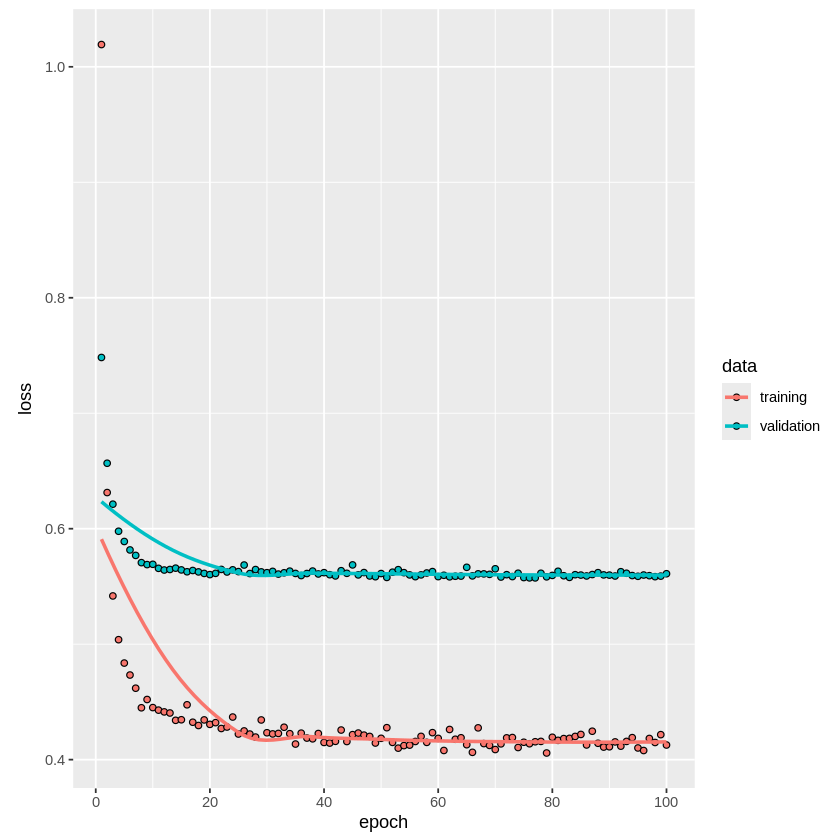

In [ ]:
arnnd <- keras_model_sequential() %>%
  layer_dense(units = 32, activation = 'relu',
              input_shape = ncol(x)) %>%
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 1)

arnnd %>% compile(loss = "mse",
                  optimizer = optimizer_rmsprop())

history <- arnnd %>% fit(x[istrain, ], arframe[istrain, "log_volume"],
                         epochs = 100, batch_size = 32,
                         validation_data =list(x[!istrain, ], arframe[!istrain, "log_volume"]))

plot(history)

npred <- predict(arnnd, x[!istrain, ])
round( 1 - mean((arframe[!istrain, "log_volume"] - npred)^2) / V0  , digits=4 )



---



<center>
  <h1 style="font-size: 36px">Training complete🥳! Time to deploy your model and conquer the world <br> (or at least win that cat image classification competition😄).</h1>
</center>
